In [188]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
%autoreload 2

In [190]:
import pandas as pd
import networkx as nx
from uuid import uuid4
from pprint import pprint

from recordlinkage import KMeansClassifier, ECMClassifier

In [191]:
bot = pd.read_csv('01_cleaned_books_of_titans.csv', index_col=[0])
bot = bot.fillna('')
bot.head(1)

,book,author,num_authors,title,subtitle,author_1_given_name,author_1_middle_name,author_1_surname,author_2_given_name,author_2_middle_name,author_2_surname
uuid,,,,,,,,,,,
bot:0064c59e-fc4a-4255-945c-5ede8ce020e0,In Praise of Shadows,['Junichiro Tanizaki'],1,in praise of shadows,,junichiro,,tanizaki,,,


In [192]:
features = pd.read_csv('03_comparison_results.csv', index_col=[0,1])
features.head(1)

,,title,subtitle,author_1_given_name,author_1_middle_name,author_1_surname,author_2_given_name,author_2_middle_name,author_2_surname
uuid_1,uuid_2,,,,,,,,
bot:00823451-fa04-4ba1-9452-5df7daa16612,bot:0064c59e-fc4a-4255-945c-5ede8ce020e0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN


In [193]:
# Really basic scoring. Do better.
# Sum the comparison results...
features['match_score'] = features.sum(axis=1)

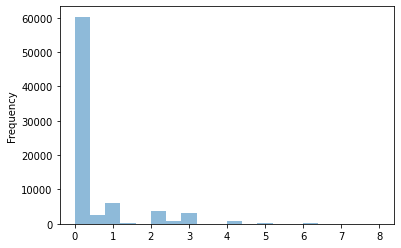

In [194]:
ax = features['match_score'].plot.hist(bins=20, alpha=0.5)

In [195]:
# Better matching, with weighting on the title and first author.
def score_book_matches(row):
    """ Intelligent(ish) scoring.
    """
    author_1_name_score = (
        (row['author_1_given_name'] + row['author_1_middle_name'] + row['author_1_surname'])
    )
    title_score = (
        row['title'] + row['subtitle']
    )
    if author_1_name_score >= 2.0 and row['title'] < 1.0:
        # Author 1 is basically the same. Discount it, to maximise the differences of title.
        return (row['title'] + row['subtitle']) * 4
    else:
        # Just dumb sum again.
        return row.sum()

features['match_score'] = features.apply(score_book_matches, axis=1)
features = features.sort_values(by='match_score', ascending=False)

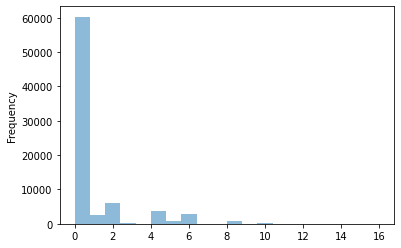

In [196]:
ax = features['match_score'].plot.hist(bins=20, alpha=0.5)

In [197]:
borderline = features.loc[
    (features['match_score'] > 2)
    & (features['match_score'] < 5.57)
]
for left, right in borderline.head(10).index.values:
    match = (
        tuple(bot[['book', 'author']].loc[left]),
        tuple(bot[['book', 'author']].loc[right]),
        borderline.loc[(left, right)]['match_score']
    )
    pprint(match)

(('The Millionaire Real Estate Investor', "['Gary Keller']"),
 ('The Millionaire Real Estate Agent', "['Gary Keller']"),
 5.567594231104273)
(('The 22 Immutable Laws of Marketing: Violate Them at Your Own Risk!',
  "['Al Ries', 'Jack Trout']"),
 ('The 22 Immutable Laws of Branding', "['Al Ries', 'Laura Ries']"),
 5.549450653621209)
(('The 22 Immutable Laws of Marketing', "['Al Ries', 'Jack Trout']"),
 ('The 22 Immutable Laws of Branding', "['Al Ries', 'Laura Ries']"),
 5.549450653621209)
(('The 22 Immutable Laws of Branding', "['Al Ries', 'Laura Ries']"),
 ('The 22 Immutable Laws of Marketing', "['Al Ries', 'Jack Trout']"),
 5.549450653621209)
(('The 22 Immutable Laws of Marketing', "['Al Ries', 'Jack Trout']"),
 ('The 22 Immutable Laws of Branding', "['Al Ries', 'Laura Ries']"),
 5.549450653621209)
(('The 22 Immutable Laws of Marketing: Violate Them at Your Own Risk!',
  "['Al Ries', 'Jack Trout']"),
 ('The 22 Immutable Laws of Branding', "['Al Ries', 'Laura Ries']"),
 5.5494506536212

In [198]:
matches = features.loc[features['match_score'] < 5.57]
f"{len(matches)} matches from {len(features)} comparisons."

'73560 matches from 78128 comparisons.'

In [199]:
# Try Something Fancy
features = features.drop(columns='match_score')
features = features.fillna(-1)

In [200]:
kmeans = KMeansClassifier()
result_kmeans = kmeans.fit_predict(features)
f"{len(result_kmeans)} matches from {len(features)} comparisons."

'614 matches from 78128 comparisons.'

In [201]:
for left, right in features.loc[result_kmeans].head(5).index.values:
    match = (
        tuple(bot[['book', 'author']].loc[left]),
        tuple(bot[['book', 'author']].loc[right]),
    )
    pprint(match)

(('Freakonomics: A Rogue Economist Explores the Hidden Side of Everything',
  "['Steven D. Levitt', 'Stephen J. Dubner']"),
 ('Freakonomics: A Rogue Economist Explores the Hidden Side of Everything',
  "['Steven D. Levitt', 'Stephen J. Dubner']"))
(('Remote: Office Not Required', "['Jason Fried', 'David Heinemeier Hansson']"),
 ('Remote: Office Not Required', "['Jason Fried', 'David Heinemeier Hansson']"))
(('About Face: The Odyssey of an American Warrior',
  "['David H. Hackworth', 'Julie Sherman']"),
 ('About Face: The Odyssey of an American Warrior',
  "['David H. Hackworth', 'Julie Sherman']"))
(('About Face: The Odyssey of an American Warrior',
  "['David H. Hackworth', 'Julie Sherman']"),
 ('About Face: The Odyssey of an American Warrior',
  "['David H. Hackworth', 'Julie Sherman']"))
(('Freakonomics', "['Steven D. Levitt', 'Stephen J. Dubner']"),
 ('Freakonomics: A Rogue Economist Explores the Hidden Side of Everything',
  "['Steven D. Levitt', 'Stephen J. Dubner']"))


In [202]:
# Or something else fancy
ecm = ECMClassifier(binarize=0.8)
result_ecm = ecm.fit_predict(features)
f"{len(result_ecm)} matches from {len(features)} comparisons."

'8927 matches from 78128 comparisons.'

In [203]:
for left, right in features.loc[result_ecm].head(5).index.values:
    match = (
        tuple(bot[['book', 'author']].loc[left]),
        tuple(bot[['book', 'author']].loc[right]),
    )
    pprint(match)

(('Freakonomics: A Rogue Economist Explores the Hidden Side of Everything',
  "['Steven D. Levitt', 'Stephen J. Dubner']"),
 ('Freakonomics: A Rogue Economist Explores the Hidden Side of Everything',
  "['Steven D. Levitt', 'Stephen J. Dubner']"))
(('Remote: Office Not Required', "['Jason Fried', 'David Heinemeier Hansson']"),
 ('Remote: Office Not Required', "['Jason Fried', 'David Heinemeier Hansson']"))
(('About Face: The Odyssey of an American Warrior',
  "['David H. Hackworth', 'Julie Sherman']"),
 ('About Face: The Odyssey of an American Warrior',
  "['David H. Hackworth', 'Julie Sherman']"))
(('About Face: The Odyssey of an American Warrior',
  "['David H. Hackworth', 'Julie Sherman']"),
 ('About Face: The Odyssey of an American Warrior',
  "['David H. Hackworth', 'Julie Sherman']"))
(('Freakonomics', "['Steven D. Levitt', 'Stephen J. Dubner']"),
 ('Freakonomics: A Rogue Economist Explores the Hidden Side of Everything',
  "['Steven D. Levitt', 'Stephen J. Dubner']"))


In [204]:
# Whats the Difference?
len(result_kmeans.difference(result_ecm))

355

In [205]:
for left, right in features.loc[result_kmeans.difference(result_ecm)].index.values:
    match = (
        tuple(bot[['book', 'author']].loc[left]),
        tuple(bot[['book', 'author']].loc[right]),
    )
    pprint(match)

(('Abundance', "['Peter H. Diamandis', 'Steven Kotler']"),
 ('Zero to One: Notes on Startups, or How to Build the Future',
  "['Peter Thiel', 'Blake Masters']"))
(('Buddhism For Dummies',
  "['Jonathan Landaw', 'Stephan Bodian', 'Gudrun Bhnemann']"),
 ('Abundance', "['Peter H. Diamandis', 'Steven Kotler']"))
(('Getting to Yes', "['William L. Ury', 'Roger Fisher', 'Bruce M. Patton']"),
 ('Getting to Yes', "['Roger Fisher', 'William Ury']"))
(('Good Omens', "['Neil Gaiman', 'Terry Pratchett']"),
 ('Getting to Yes', "['Roger Fisher', 'William Ury']"))
(('Good Omens', "['Neil Gaiman', 'Terry Pratchett']"),
 ('Getting to Yes', "['William L. Ury', 'Roger Fisher', 'Bruce M. Patton']"))
(('The Nautilus Bulletins', "['Dr Alan Stuart Radley', 'Mr Arthur Jones']"),
 ('The Intelligent Investor', "['Benjamin Graham', 'Jason Zweig']"))
(('Getting to Yes', "['Roger Fisher', 'William Ury']"),
 ('Getting to Yes', "['William L. Ury', 'Roger Fisher', 'Bruce M. Patton']"))
(('Getting to Yes', "['Roger Fis

(('The Starfish and the Spider', "['Ori Brafman', 'Rod A. Beckstrom']"),
 ('The Start-up of You', "['Reid Hoffman', 'Ben Casnocha']"))
(('The Art of Asking', "['Amanda Palmer', 'Bren Brown']"),
 ('The Art of Robert E. McGinnis', "['Robert E. McGinnis', 'Art Scott']"))
(('The Art of Asking', "['Amanda Palmer', 'Bren Brown']"),
 ('Dreaming Yourself Awake', "['B. Alan Wallace', 'Brian Hodel']"))
(('Abundance: The Future Is Better Than You Think',
  "['Peter H. Diamandis', 'Steven Kotler']"),
 ('Buddhism For Dummies',
  "['Jonathan Landaw', 'Stephan Bodian', 'Gudrun Bhnemann']"))
(('Abundance: The Future Is Better Than You Think',
  "['Peter H. Diamandis', 'Steven Kotler']"),
 ('Freakonomics: A Rogue Economist Explores the Hidden Side of Everything',
  "['Steven D. Levitt', 'Stephen J. Dubner']"))
(('Abundance: The Future Is Better Than You Think',
  "['Peter H. Diamandis', 'Steven Kotler']"),
 ('The Macrobiotic Way', "['Michio Kushi', 'Stephen Blauer', 'Wendy Esko']"))
(('The China Study'

(('Zero to One: Notes on Startups, or How to Build the Future',
  "['Peter Thiel', 'Blake Masters']"),
 ('Au Contraire: Figuring Out the French',
  "['Gilles Asselin', 'Ruth Mastron']"))
(('On Grief and Grieving', "['Elisabeth Kbler-Ross', 'David Kessler']"),
 ('Happy Money: The Science of Happier Spending',
  "['Elizabeth Dunn', 'Michael Norton']"))
(('On Grief and Grieving', "['Elisabeth Kbler-Ross', 'David Kessler']"),
 ('Happy Money: The Science of Happier Spending',
  "['Elizabeth Dunn', 'Michael Norton']"))
(('On Grief and Grieving', "['Elisabeth Kbler-Ross', 'David Kessler']"),
 ('Happy Money: The Science of Happier Spending',
  "['Elizabeth Dunn', 'Michael Norton']"))
(('National Geographic Field Guide to the Birds of North America',
  "['Jon L. Dunn', 'Jonathan Alderfer']"),
 ('Trillion Dollar Coach',
  "['Eric Schmidt', 'Jonathan Rosenberg', 'Alan Eagle']"))
(('The Art of Nonfiction: A Guide for Writers and Readers',
  "['Ayn Rand', 'Robert Mayhew', 'Peter Schwartz']"),
 ('Th

  "['Roy Choi', 'Tien Nguyen', 'Natasha Phan']"))
(('The Art of Possibility', "['Rosamund Stone Zander', 'Benjamin Zander']"),
 ('The Art of Robert E. McGinnis', "['Robert E. McGinnis', 'Art Scott']"))
(('The Art of Possibility', "['Rosamund Stone Zander', 'Benjamin Zander']"),
 ('The Art of Asking', "['Amanda Palmer', 'Bren Brown']"))
(('The Art of Possibility', "['Rosamund Stone Zander', 'Benjamin Zander']"),
 ('The Art of Nonfiction: A Guide for Writers and Readers',
  "['Ayn Rand', 'Robert Mayhew', 'Peter Schwartz']"))
(('The Startup Community Way', "['Brad Feld', 'Ian Hathaway']"),
 ('The Start-up of You', "['Reid Hoffman', 'Ben Casnocha']"))
(('The Startup Community Way', "['Brad Feld', 'Ian Hathaway']"),
 ('The Starfish and the Spider', "['Ori Brafman', 'Rod A. Beckstrom']"))
(('The Startup Community Way', "['Brad Feld', 'Ian Hathaway']"),
 ('Switch', "['Chip Heath', 'Dan Heath']"))
(('American Prometheus', "['Kai Bird', 'Martin J. Sherwin']"),
 ('About Face: The Odyssey of an A

(('The Net and the Butterfly', "['Olivia Fox Cabane', 'Judah Pollack']"),
 ('The One Minute Manager', "['Kenneth H. Blanchard', 'Spencer Johnson']"))
(('The Net and the Butterfly', "['Olivia Fox Cabane', 'Judah Pollack']"),
 ('The ONE Thing', "['Gary Keller', 'Jay Papasan']"))
(('The Net and the Butterfly', "['Olivia Fox Cabane', 'Judah Pollack']"),
 ('The Mathematics of Politics', "['E. Arthur Robinson', 'Daniel H. Ullman']"))
(('The Start-up of You', "['Reid Hoffman', 'Ben Casnocha']"),
 ('The Starfish and the Spider', "['Ori Brafman', 'Rod A. Beckstrom']"))
(('The Start-up of You', "['Reid Hoffman', 'Ben Casnocha']"),
 ('The Startup Community Way', "['Brad Feld', 'Ian Hathaway']"))
(('Creativity, Inc.', "['Ed Catmull', 'Amy Wallace']"),
 ('Tihkal: A Continuation', "['Alexander', 'Ann Shulgin']"))
(('Creativity, Inc.', "['Ed Catmull', 'Amy Wallace']"),
 ('Creativity in Business', "['Michael Ray', 'Rochelle Myers']"))
(('The Gamble: Choice and Chance in the 2012 Presidential Election'

In [206]:
# Looks like ECM is better!
matches = result_ecm

In [207]:
matches.to_frame().to_csv('04_matches.csv')

In [208]:
# Cluster Matches
G = nx.Graph()
# Add nodes
G.add_nodes_from(
    set(matches.get_level_values(0) + matches.get_level_values(1))
)
# Add edges
G.add_edges_from(matches.values)

In [209]:
comparison_clusters = []
for cluster in sorted(nx.connected_components(G), key=len, reverse=True):
    cluster_id = f"match_cluster:{uuid4()}"
    for record_id in cluster:
        comparison_clusters.append(
            (record_id, cluster_id, len(cluster))
        )
clusters = pd.DataFrame(comparison_clusters, columns=['uuid', 'cluster_id', 'cluster_size'])
clusters = clusters.set_index('uuid')
clusters.head()

,cluster_id,cluster_size
uuid,,
bot:db8cb90c-38e5-40f7-8a36-17b0ed0ef0a6,match_cluster:448ec675-5631-4825-a0a3-506d4d2e...,127
bot:5ad30206-7615-49fd-85ae-3ff0815c42e7,match_cluster:448ec675-5631-4825-a0a3-506d4d2e...,127
bot:a3a48038-70d1-4ba7-9f54-9bf2076f5412,match_cluster:448ec675-5631-4825-a0a3-506d4d2e...,127
bot:f76ffd02-bf86-4a8a-9ed4-a10d11840769,match_cluster:448ec675-5631-4825-a0a3-506d4d2e...,127
bot:056f5cf3-2f0b-4019-b4d0-b962222add17,match_cluster:448ec675-5631-4825-a0a3-506d4d2e...,127


In [210]:
clusters.to_csv('04_match_clusters.csv')